In [1]:
%%capture

# Libraries
!pip install lifelines
!pip install shap
!pip install optuna
!pip install cmaes
!pip install scikit-survival

In [ ]:
# Imports
seed = 1

import os
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics import roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, brier_score
from sksurv.nonparametric import kaplan_meier_estimator

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler

import shap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# **Functions**

In [3]:
# Importing the functions
!gdown 1-uw7N4Vx5eNLso_NQ64uObFTlwXhdnda --quiet

from functions_ml_survival import *

# **Comparison of survival models**

## **Train e Test**



In [4]:
# Lung Dataset
!gdown 1vqYdyN9E9mV1MRTIcKJxzImpl8NRgoCt --quiet

In [5]:
# Reading data
df_pulm = pd.read_csv('pulmao.csv')
print(df_pulm.shape)
df_pulm.head(3)

(45729, 50)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,MORFO,EC,...,PRESENCA_META,PRESENCA_REC,obito_geral,obito_cancer,sobrevida_ano1,sobrevida_ano2,sobrevida_ano3,sobrevida_ano4,sobrevida_ano5,meses_diag
0,612374,2,51,2,3550308,2,2,C341,81403,IV,...,1,0,1,1,0,0,0,0,0,5
1,8,9,56,2,3548708,1,1,C342,83233,IB,...,0,0,0,0,1,1,1,1,1,61
2,8,9,53,1,3550308,9,2,C341,81403,IIIB,...,0,0,0,0,1,1,1,1,1,61


In [6]:
# Exclude patients with morphology ending in 2
df_pulm = df_pulm[~df_pulm['MORFO'].astype(str).str.endswith('2')]

# Exclude patients with morphology starting with 9
df_pulm = df_pulm[~df_pulm.MORFO.isin([90703])]

df_pulm.shape

(45719, 50)

In [7]:
# Columns
df_pulm.columns

Index(['INSTITU', 'ESCOLARI', 'IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV',
       'TOPO', 'MORFO', 'EC', 'ECGRUP', 'NENHUM', 'CIRURGIA', 'RADIO',
       'QUIMIO', 'IMUNO', 'OUTROS', 'NENHUMAPOS', 'CIRURAPOS', 'RADIOAPOS',
       'QUIMIOAPOS', 'IMUNOAPOS', 'OUTROAPOS', 'ULTINFO', 'CONSDIAG',
       'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'DSCINST', 'IBGEATEN',
       'HABILIT2', 'DRS_INST', 'RRAS_INST', 'ECGRUP_CAT', 'ULTIDIAG',
       'CONSDIAG_CAT', 'TRATCONS_CAT', 'DIAGTRAT_CAT', 'PRESENCA_META',
       'PRESENCA_REC', 'obito_geral', 'obito_cancer', 'sobrevida_ano1',
       'sobrevida_ano2', 'sobrevida_ano3', 'sobrevida_ano4', 'sobrevida_ano5',
       'meses_diag'],
      dtype='object')

In [8]:
# Data Splitting into Training and Testing Sets
# Separate features (X) and target variable (y)
X = df_pulm.drop(['obito_geral'], axis=1)  # Features (all columns except 'obito_geral')
y = df_pulm['obito_geral']  # Target variable ('obito_geral')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  # 80% train, 20% test
                                                    random_state=seed,  # For reproducibility
                                                    stratify=y)  # Stratified sampling to maintain class proportions

# Print the shapes of the resulting datasets
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (36575, 49)
y_train: (36575,)
X_test: (9144, 49)
y_test: (9144,)


In [9]:
# Saving the Datasets
# Concatenate features and target variable for training and testing sets
df_treino = pd.concat([X_train, y_train], axis=1)  # Combine X_train and y_train into a single DataFrame
df_teste = pd.concat([X_test, y_test], axis=1)  # Combine X_test and y_test into a single DataFrame

df_treino.to_csv('pulmao_treino.csv', index=False)  # Save the training DataFrame to 'pulmao_treino.csv'
df_teste.to_csv('pulmao_teste.csv', index=False)  # Save the testing DataFrame to 'pulmao_teste.csv'

## **Kaplan-Meier**

In [ ]:
# Reading Test Data
df_teste = pd.read_csv('/content/pulmao_teste.csv')  # Load the test data from the CSV file
print(df_teste.shape)  # Print the dimensions of the test DataFrame
df_teste.head(3)  # Display the first 3 rows of the test DataFrame

(9144, 50)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,MORFO,EC,...,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano2,sobrevida_ano3,sobrevida_ano4,sobrevida_ano5,meses_diag,obito_geral
0,16624,3,54,2,3550308,2,2,C349,81403,IV,...,1,0,1,0,0,0,0,0,7,1
1,612374,9,85,1,3550308,2,1,C341,80703,IIIA,...,0,0,0,1,0,0,0,0,15,1
2,16624,1,55,1,3526209,9,2,C349,80203,IIIB,...,0,0,1,0,0,0,0,0,6,1


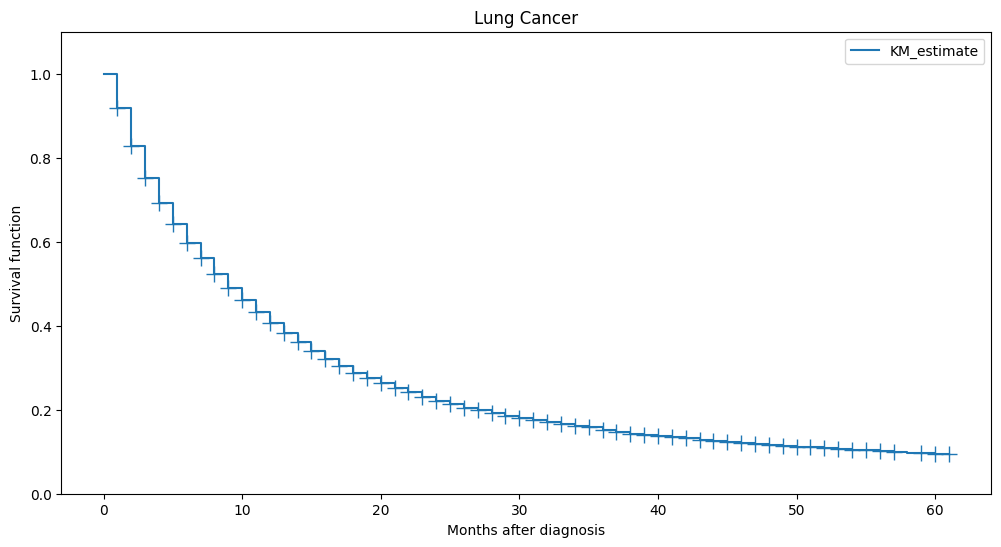

In [ ]:
# Kaplan-Meier Survival Curve Plot
# Extract event (E) and time (T) data from the test set
E = (df_teste.obito_geral == 1)  # Event indicator (obito_geral = 1 means event occurred)
T = df_teste.meses_diag  # Time to event (months since diagnosis)

title = f'Lung Cancer'  # Set the plot title

kmf = KaplanMeierFitter()  # Initialize the Kaplan-Meier fitter

fig = plt.figure(figsize=(12, 6))  # Create the plot figure
ax = plt.subplot(111)  # Create the axes for the plot

# Fit and plot the Kaplan-Meier survival curve
ax = kmf.fit(T, E).plot(ax=ax, ci_show=False, show_censors=True)  # Fit the model, plot the curve, show censoring marks
ax.set_title(title)  # Set the plot title
ax.set_xlabel('Months after diagnosis')  # Set the x-axis label
ax.set_ylabel('Survival function')  # Set the y-axis label
plt.ylim([0, 1.1])  # Set y-axis limits
plt.show()  # Display the plot

In [ ]:
# Survival at 1, 3, and 5 Years
# Access survival probabilities at specific time points (12, 36, and 60 months)
kmf.survival_function_.loc[[12, 36, 60]]

,KM_estimate
timeline,
12.0,0.407186
36.0,0.152633
60.0,0.095040


## **Machine Learning Survival**

### **Data preparation for survival models**

In [10]:
# Reading Training Data
df_treino = pd.read_csv('/content/pulmao_treino.csv')  # Load the training data from the CSV file
print(df_treino.shape)  # Print the dimensions of the training DataFrame
df_treino.head(3)  # Display the first 3 rows of the training DataFrame

(36575, 50)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,MORFO,EC,...,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano2,sobrevida_ano3,sobrevida_ano4,sobrevida_ano5,meses_diag,obito_geral
0,22128,4,59,2,3539905,1,1,C349,80423,IV,...,1,0,1,0,0,0,0,0,2,1
1,9326,9,71,1,3501608,9,1,C341,81403,IIIA,...,0,0,1,0,0,0,0,0,13,1
2,21636,2,49,2,3503208,9,2,C341,80123,IV,...,1,0,1,0,0,0,0,0,2,1


In [11]:
# Reading Test Data
df_teste = pd.read_csv('/content/pulmao_teste.csv')  # Load the test data from the CSV file
print(df_teste.shape)  # Print the dimensions of the test DataFrame
df_teste.head(3)  # Display the first 3 rows of the test DataFrame

(9144, 50)


,INSTITU,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,MORFO,EC,...,PRESENCA_META,PRESENCA_REC,obito_cancer,sobrevida_ano1,sobrevida_ano2,sobrevida_ano3,sobrevida_ano4,sobrevida_ano5,meses_diag,obito_geral
0,16624,3,54,2,3550308,2,2,C349,81403,IV,...,1,0,1,0,0,0,0,0,7,1
1,612374,9,85,1,3550308,2,1,C341,80703,IIIA,...,0,0,0,1,0,0,0,0,15,1
2,16624,1,55,1,3526209,9,2,C349,80203,IIIB,...,0,0,1,0,0,0,0,0,6,1


In [12]:
# Y train and test for survival data (Death, Months from Diagnosis)
y_train = Surv.from_arrays(df_treino.obito_geral, df_treino.meses_diag)  # Create survival data for training set
y_test = Surv.from_arrays(df_teste.obito_geral, df_teste.meses_diag)  # Create survival data for test set

In [13]:
# X train and test after removing unnecessary columns, including Death and Months from Diagnosis (which go to the target Y)
list_drop = ['sobrevida_ano1', 'sobrevida_ano2', 'sobrevida_ano3', 'sobrevida_ano4',
             'sobrevida_ano5', 'obito_geral', 'obito_cancer', 'meses_diag',
             'ECGRUP', 'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'IMUNO', 'OUTROS',
             'NENHUMAPOS', 'CIRURAPOS', 'RADIOAPOS',  'QUIMIOAPOS', 'IMUNOAPOS',
             'OUTROAPOS', 'ULTINFO', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RRAS',
             'DSCINST', 'RRAS_INST', 'ECGRUP_CAT', 'ULTIDIAG', 'CONSDIAG_CAT',
             'PRESENCA_META', 'PRESENCA_REC']

X_train = df_treino.drop(list_drop, axis=1)  # Remove specified columns from the training dataset

X_test = df_teste.drop(list_drop, axis=1)  # Remove specified columns from the test dataset

In [14]:
# Preprocessing of Training and Test data
X_train, X_test, feat_cols, enc, norm = preprocessing(X_train, X_test,
                                                      norm_name='StandardScaler',  # Specify normalization method
                                                      return_enc_norm=True,  # Return encoder and normalizer objects
                                                      random_state=seed)  # Set random state for reproducibility

# Display the shapes of the processed training and test datasets
X_train.shape, X_test.shape

((36575, 17), (9144, 17))

In [15]:
# Features columns
feat_cols

Index(['INSTITU', 'ESCOLARI', 'IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV',
       'TOPO', 'MORFO', 'EC', 'ANODIAG', 'DRS', 'IBGEATEN', 'HABILIT2',
       'DRS_INST', 'TRATCONS_CAT', 'DIAGTRAT_CAT'],
      dtype='object')

### **Random Survival Forest**

#### **Base Model**

In [ ]:
# RSF (Random Survival Forest) Model
rsf = RandomSurvivalForest(max_depth=8, n_jobs=-1, random_state=seed)  # Initialize the RSF model with a max depth of 8
rsf.fit(X_train, y_train)  # Train the model using the training data

# Calculate the C-index for the test dataset
c_index_base = rsf.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_base}')
print(f'C-Index Train: {rsf.score(X_train, y_train)}')

C-Index Test: 0.7245481065475833
C-Index Train: 0.7348579340357104


C-Index IPCW Test: 0.7211511558174767
C-Index IPCW Train: 0.7312645677046244

Integrated Brier Score (IBS): 0.11815395744711102

Brier Score:
    > 1 year = 0.1861580716506113
    > 3 years = 0.09832111157395079
    > 5 years = 0.0673210343235073



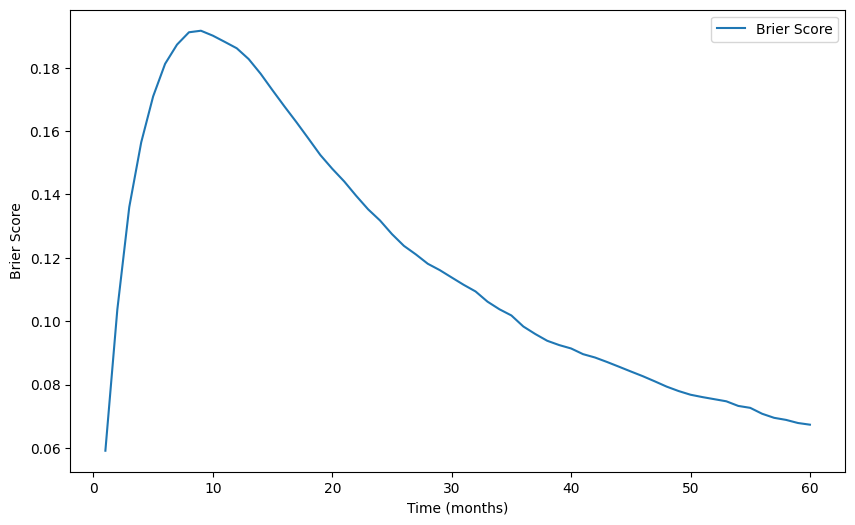

In [ ]:
# C-Index IPCW and Brier Score
c_index_ipcw_brier_score(rsf, X_train, y_train, X_test, y_test)  # Compute and evaluate the IPCW C-index and Brier Score

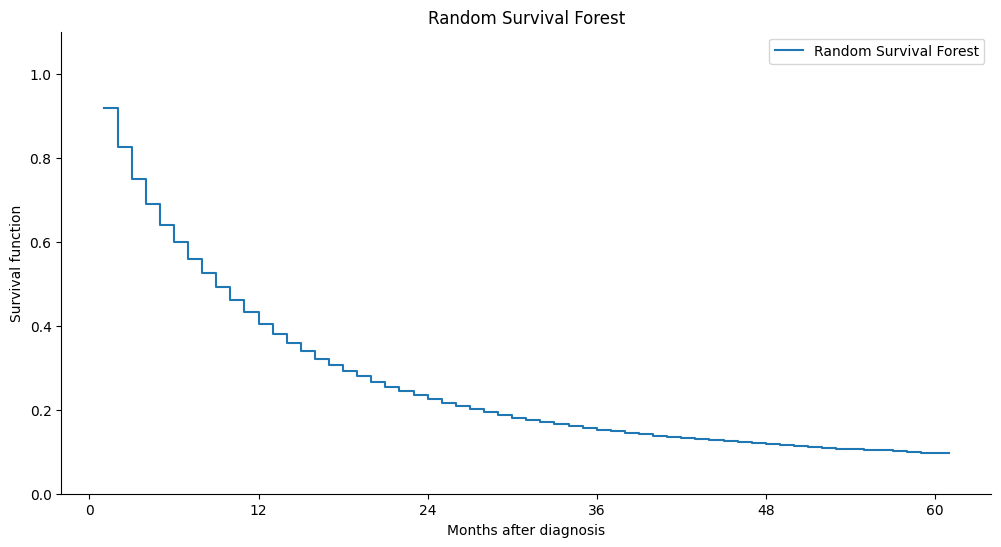

In [ ]:
# Survival prediction (Probability)
surv_rsf = rsf.predict_survival_function(X_test, return_array=True)  # Predict survival probabilities for the test set
surv_rsf_mean = surv_rsf.mean(axis=0)  # Compute the mean survival probability across samples

# Plot the predicted survival curve
name = 'Random Survival Forest'

plot_survival_curve(rsf.unique_times_, surv_rsf_mean, name=name)  # Generate and display the survival curve

In [ ]:
# Survival probability at 12, 36, and 60 months
print(f'12 months: {surv_rsf_mean[12]}')  # Print survival probability at 12 months
print(f'36 months: {surv_rsf_mean[36]}')  # Print survival probability at 36 months
print(f'60 months: {surv_rsf_mean[60]}')  # Print survival probability at 60 months

12 months: 0.38102438605556654
36 months: 0.1487992872440069
60 months: 0.09635700662781473


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=seed)  # Create a 10-fold cross-validation strategy

# Function to compute the C-index for a given estimator
def c_index(estimator, X, y):
    cindex = estimator.score(X, y)  # Compute the C-index score
    return cindex

# Objective function for hyperparameter optimization
def objective(trial):
    # Define hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 130)  # Number of trees in the forest
    max_depth = trial.suggest_int('max_depth', 4, 9)  # Maximum depth of each tree
    min_samples_split = trial.suggest_int('min_samples_split', 3, 12)  # Min samples required to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 12)  # Min samples required at a leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.75, 1.0])  # Feature selection strategy
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])  # Whether to use bootstrap sampling

    # Create and train the model with the suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=seed,
        n_jobs=-1
    )

    # Perform cross-validation and return the mean C-index score
    return cross_val_score(rsf, X_train, y_train, cv=kf, scoring=c_index).mean()

**RandomSampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'pulm_opt_rsf_rand.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=seed),
                                study_name='RSF_RandomSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 91, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_rand = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_rand.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_rand = rsf_rand.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {rsf_rand.score(X_train, y_train)}')

C-Index Test: 0.7244841155783822
C-Index Train: 0.7352814701692506


**TPESampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'pulm_opt_rsf_tpe.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),
                                study_name='RSF_TPESampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 32.4 ms, sys: 0 ns, total: 32.4 ms
Wall time: 43.6 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_tpe = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_tpe.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_tpe = rsf_tpe.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {rsf_tpe.score(X_train, y_train)}')

C-Index Test: 0.7246542502980833
C-Index Train: 0.7351423600075538


**CmaEsSampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'pulm_opt_rsf_cma.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),
                                study_name='RSF_CmaEsSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 15.6 ms, sys: 1.99 ms, total: 17.6 ms
Wall time: 17.6 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best hyperparameters after optimization

Best parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
rsf_cma = RandomSurvivalForest(**best_params, random_state=seed)  # Initialize the RSF model with the best parameters
rsf_cma.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_cma = rsf_cma.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_cma}')
print(f'C-index Train: {rsf_cma.score(X_train, y_train)}')

C-Index Test: 0.7238844608569728
C-index Train: 0.7359230431192174


#### **Best Random Survival Forest Model**

In [ ]:
# Best RSF model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for different models
models = [rsf, rsf_rand, rsf_tpe, rsf_cma]  # List of the corresponding models

# Find the index of the model with the highest C-index score
id_best_score = scores.index(max(scores))
best = models[id_best_score]  # Select the model with the best score

# Print the best model
print(best)

RandomSurvivalForest(max_depth=8, max_features='log2', min_samples_leaf=6,
                     min_samples_split=5, n_estimators=89, random_state=1)


C-Index Test: 0.7246542502980833
C-Index Train: 0.7351423600075538

C-Index IPCW Test: 0.7212434595929248
C-Index IPCW Train: 0.7315561826431171

Integrated Brier Score (IBS): 0.11827848090357182

Brier Score:
    > 1 year = 0.18627544214420058
    > 3 years = 0.09845702290003228
    > 5 years = 0.0674758726756184



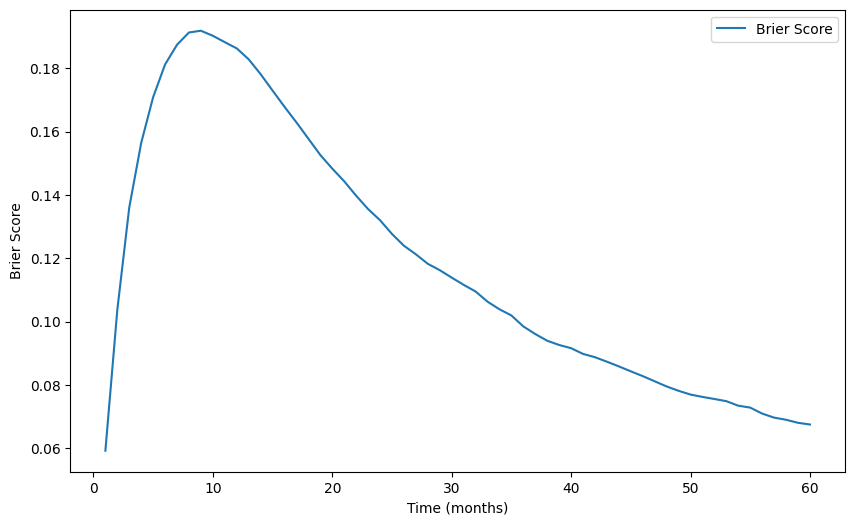

In [ ]:
# Metrics of the best RSF model
final_c_index = best.score(X_test, y_test)  # Compute the final C-index for the test dataset

# Print the C-index for both test and training datasets
print(f'C-Index Test: {final_c_index}')
print(f'C-Index Train: {best.score(X_train, y_train)}\n')

# Compute and display the IPCW C-index and Brier Score for the best model
c_index_ipcw_brier_score(best, X_train, y_train, X_test, y_test)

In [ ]:
# Best features by permutation importance
calculate_permutation_importance(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.073295,0.002760
DIAGTRAT_CAT,0.035232,0.000659
TRATCONS_CAT,0.030504,0.001293
MORFO,0.005323,0.000727
TOPO,0.003355,0.000399
CATEATEND,0.003290,0.000424
SEXO,0.002738,0.000412
DIAGPREV,0.002733,0.000214
IDADE,0.001486,0.000135
INSTITU,0.001227,0.000140


PermutationExplainer explainer: 9145it [1:02:15,  2.44it/s]                          


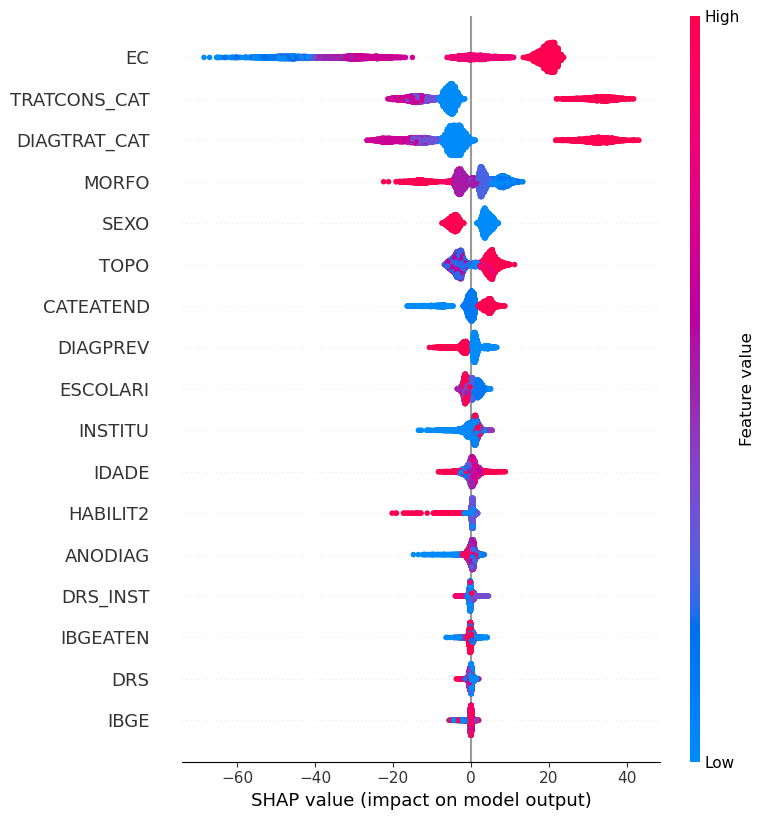

In [ ]:
# Best features by SHAP
explainer = shap.Explainer(best.predict, X_train, seed=seed,  # Create a SHAP explainer for the best model
                           output_names=feat_cols,  # Specify the feature names
                           n_jobs=-1)  # Use multiple jobs for parallel computation

shap_values = explainer(X_test)  # Calculate SHAP values for the test set

# Plot the SHAP summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

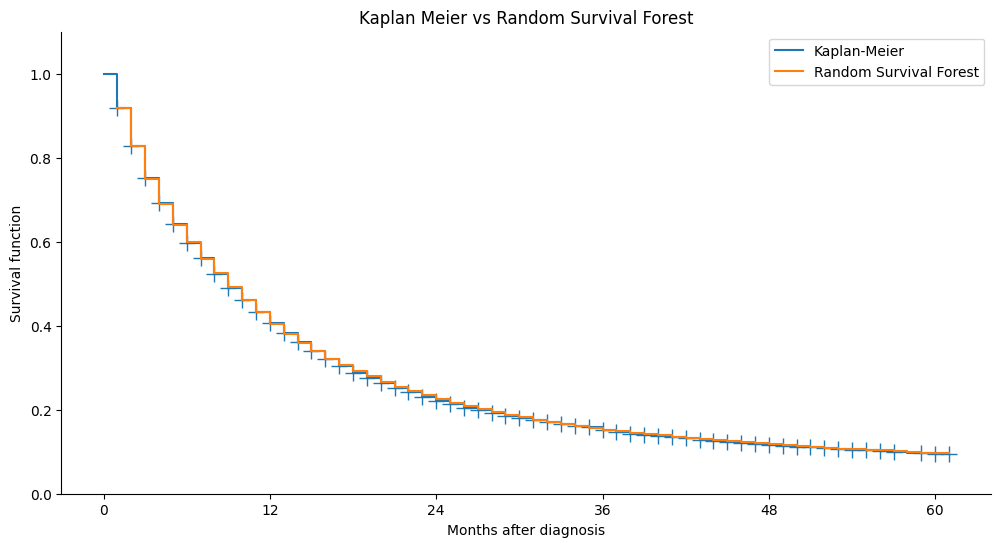

In [ ]:
# Comparison of survival curves
name = 'Random Survival Forest'  # Name of the model to be displayed on the plot

# Predict survival functions for the test set and compute the mean survival function
surv_rsf = best.predict_survival_function(X_test, return_array=True)
surv_rsf_mean = surv_rsf.mean(axis=0)  # Compute the mean survival function across all samples

# Plot the survival curve and compare with Kaplan-Meier (KM) estimates
plot_survival_curve(best.unique_times_, surv_rsf_mean,
                    name=name, compare_km=True, test_df=df_teste)  # Plot the survival curve and compare with the test dataset

### **Gradient Boosting Survival**

#### **Base Model**

In [ ]:
%%time
# GBS (Gradient Boosting Survival) Model
gb = GradientBoostingSurvivalAnalysis(n_estimators=100, max_depth=5,  # Initialize the GBS model with 100 estimators and a max depth of 5
                                      random_state=seed)  # Set the random state for reproducibility
gb.fit(X_train, y_train)  # Train the model using the training data

# Compute the C-index for the test dataset
c_index_base = gb.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_base}')
print(f'C-Index Train: {gb.score(X_train, y_train)}')

C-Index Test: 0.7315454014189049
C-Index Train: 0.7471295816973217
CPU times: user 45min 59s, sys: 3.38 s, total: 46min 3s
Wall time: 48min 20s


C-Index IPCW Test: 0.7280203096260498
C-Index IPCW Train: 0.7433209306553932

Integrated Brier Score (IBS): 0.11603809858553245

Brier Score:
    > 1 year = 0.18448337000227583
    > 3 years = 0.09553733324715279
    > 5 years = 0.06483171836819661



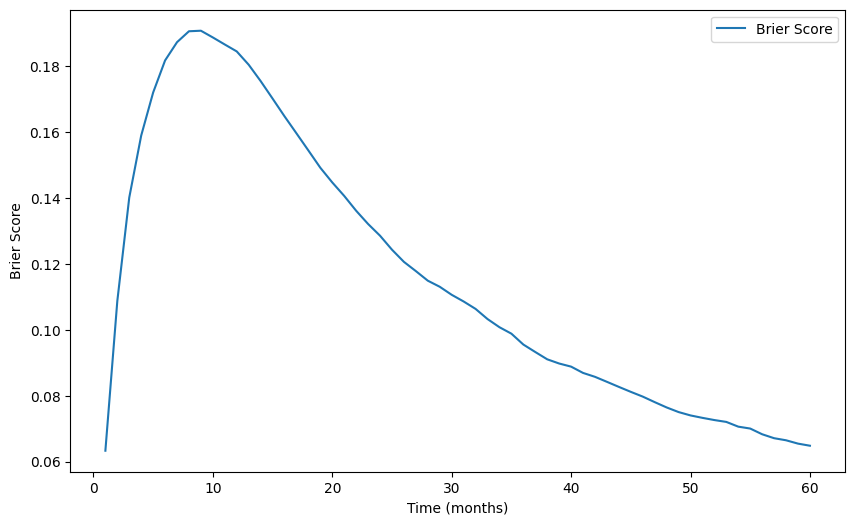

In [ ]:
# C-Index IPCW and Brier Score
c_index_ipcw_brier_score(gb, X_train, y_train, X_test, y_test)  # Compute and evaluate the IPCW C-index and Brier Score for the GBS model

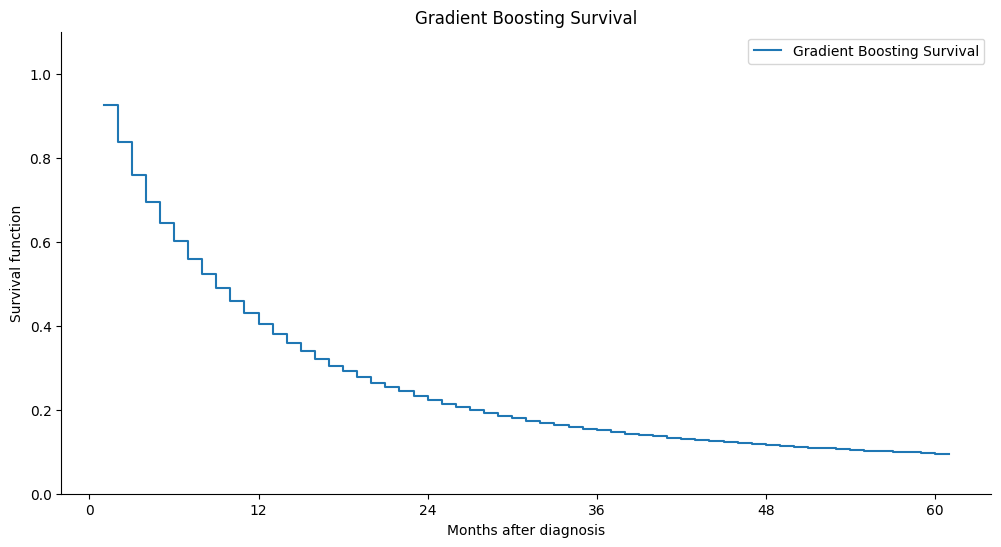

In [ ]:
# Survival function (Probability)
surv_gb = gb.predict_survival_function(X_test, return_array=True)  # Predict survival probabilities for the test set
surv_gb_mean = surv_gb.mean(axis=0)  # Compute the mean survival probability across samples

# Plot the predicted survival curve
name = 'Gradient Boosting Survival'

plot_survival_curve(gb.unique_times_, surv_gb_mean, name=name)  # Generate and display the survival curve

In [ ]:
# Survival probability at 12, 36, and 60 months
print(f'12 months: {surv_gb_mean[12]}')  # Print survival probability at 12 months
print(f'36 months: {surv_gb_mean[36]}')  # Print survival probability at 36 months
print(f'60 months: {surv_gb_mean[60]}')  # Print survival probability at 60 months

12 months: 0.3797377103815835
36 months: 0.14671086153961047
60 months: 0.09505080077880491


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(10, shuffle=True, random_state=seed)  # Create a 10-fold cross-validation strategy

# Function to compute the C-index for a given estimator
def c_index(estimator, X, y):
    cindex = estimator.score(X, y)  # Compute the C-index score
    return cindex

# Objective function for hyperparameter optimization
def objective(trial):
    # Define hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 130)  # Number of boosting stages (trees)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01)  # Learning rate for gradient boosting
    max_depth = trial.suggest_int('max_depth', 3, 7)  # Maximum depth of the individual trees
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum number of samples required to split an internal node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)  # Minimum number of samples required to be at a leaf node
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)  # Fraction of samples used for fitting each tree
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.75, 1.0])  # Feature selection strategy for each tree

    # Create and train the model with the suggested hyperparameters
    gbsa = GradientBoostingSurvivalAnalysis(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=seed
    )

    # Perform cross-validation and return the mean C-index score
    return cross_val_score(gbsa, X_train, y_train, cv=kf, scoring=c_index).mean()

**RandomSampler**

In [ ]:
%%time
# Hyperparameter optimization with Optuna - RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create an Optuna study with the goal of maximizing the objective
                            study_name='GBS_RandomSampler')  # Name the study for identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function with n_trials and use multiple jobs for parallel processing

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best parameters after optimization

Best parameters: {'n_estimators': 120, 'learning_rate': 0.19, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.9, 'max_features': 0.5}


In [ ]:
%%time
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
gbsa_rand = GradientBoostingSurvivalAnalysis(**best_params, random_state=seed)  # Initialize the GBS model with the best parameters
gbsa_rand.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_rand = gbsa_rand.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {gbsa_rand.score(X_train, y_train)}')

C-Index Test: 0.7321807937868564
C-Index Train: 0.755442836352126
CPU times: user 49min 49s, sys: 3.06 s, total: 49min 52s
Wall time: 50min 26s


**TPESampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'opt_gbs_tpe.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),
                                study_name='GBS_TPESampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 31.1 ms, sys: 993 µs, total: 32 ms
Wall time: 32.6 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best parameters after optimization

Best parameters: {'n_estimators': 130, 'learning_rate': 0.14, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.7, 'max_features': 'sqrt'}


In [ ]:
%%time
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
gbsa_tpe = GradientBoostingSurvivalAnalysis(**best_params, random_state=seed)  # Initialize the GBS model with the best parameters
gbsa_tpe.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_tpe = gbsa_tpe.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {gbsa_tpe.score(X_train, y_train)}')

C-Index Test: 0.732405136395254
C-Index Train: 0.7502286783543239
CPU times: user 47min 28s, sys: 2.8 s, total: 47min 31s
Wall time: 47min 50s


**CmaEsSampler**

In [ ]:
%%time
# Pickle filename to save the study
pickle_filename = 'opt_gbs_cma.pkl'

# Load existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)
else:
    study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),
                                study_name='GBS_CmaEsSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in batches
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)
    completed_trials = len(study.trials)
    print(f"\nTrials completed: {completed_trials}/{n_trials}")

    # Save the study after each batch
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)

CPU times: user 38.2 ms, sys: 0 ns, total: 38.2 ms
Wall time: 79.3 ms


In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)  # Print the best parameters after optimization

Best parameters: {'n_estimators': 118, 'learning_rate': 0.11, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7, 'subsample': 0.7, 'max_features': 'log2'}


In [ ]:
%%time
# Training and metrics with the best hyperparameters
best_params = study.best_params  # Get the best parameters from the study
gbsa_cma = GradientBoostingSurvivalAnalysis(**best_params, random_state=seed)  # Initialize the GBS model with the best parameters
gbsa_cma.fit(X_train, y_train)  # Train the model with the training data

# Compute the C-index for the test dataset
c_index_cma = gbsa_cma.score(X_test, y_test)

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_cma}')
print(f'C-Index Train: {gbsa_cma.score(X_train, y_train)}')

C-Index Test: 0.7323550716144214
C-Index Train: 0.7534902284405255
CPU times: user 43min 48s, sys: 2.8 s, total: 43min 51s
Wall time: 45min 34s


#### **Best Gradient Boosting Survival Model**

In [ ]:
# Best GBS model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for each model
models = [gb, gbsa_rand, gbsa_tpe, gbsa_cma]  # List of corresponding models

id_best_score = scores.index(max(scores))  # Find the index of the model with the highest C-index score
best = models[id_best_score]  # Select the best model based on the highest score

print(best)  # Print the best model

GradientBoostingSurvivalAnalysis(learning_rate=0.14, max_depth=5,
                                 max_features='sqrt', min_samples_leaf=4,
                                 min_samples_split=3, n_estimators=130,
                                 random_state=1, subsample=0.7)


C-Index Test: 0.732405136395254
C-Index Train: 0.7502286783543239

C-Index IPCW Test: 0.7288478412868703
C-Index IPCW Train: 0.7464473146459467

Integrated Brier Score (IBS): 0.11561447128739906

Brier Score:
    > 1 year = 0.183582066013627
    > 3 years = 0.09503796884294968
    > 5 years = 0.06450158491527903



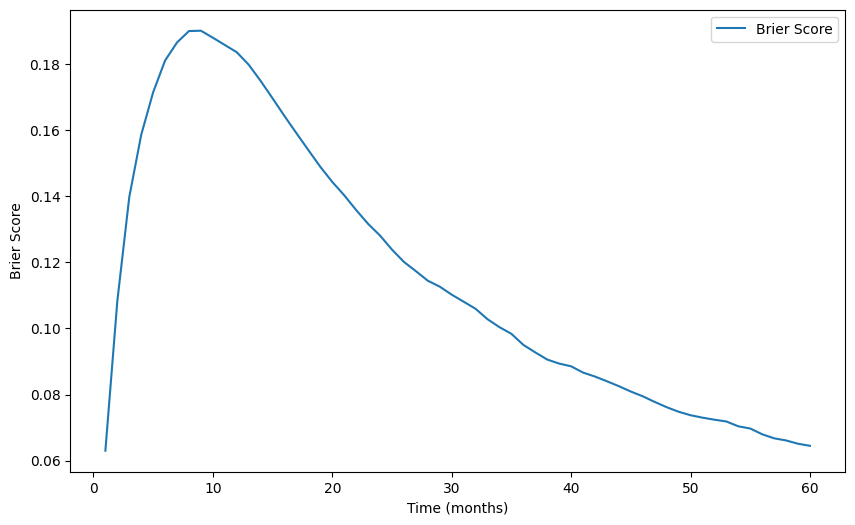

In [ ]:
# Metrics of the best GBS model
final_c_index = best.score(X_test, y_test)  # Compute the C-index for the best model on the test dataset

print(f'C-Index Test: {final_c_index}')  # Print the C-index for the test set
print(f'C-Index Train: {best.score(X_train, y_train)}\n')  # Print the C-index for the training set

# Calculate and print the IPCW and Brier score for the best model
c_index_ipcw_brier_score(best, X_train, y_train, X_test, y_test)

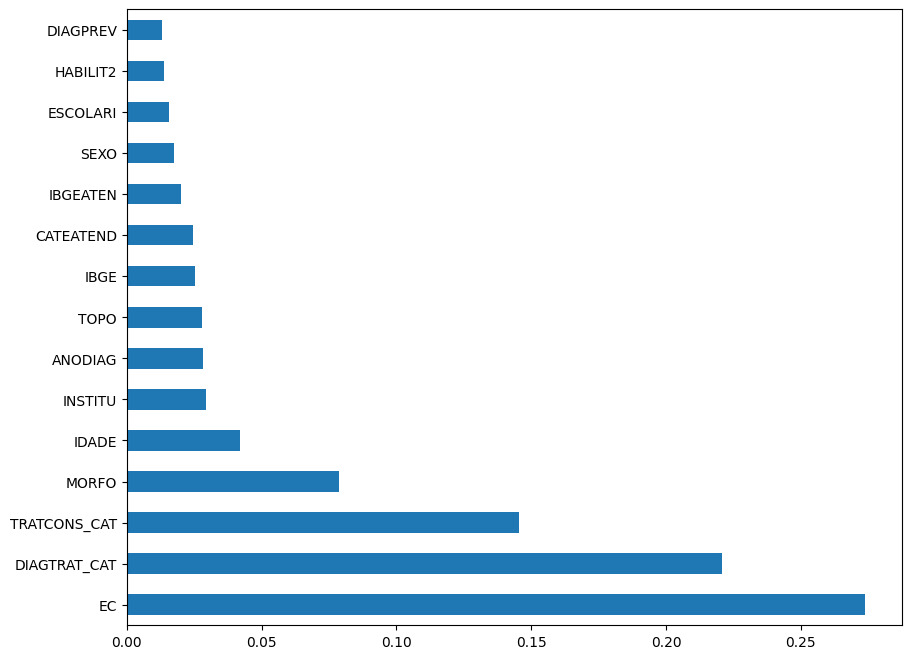

In [ ]:
# Feature Importances
feat_import = pd.Series(best.feature_importances_, index=feat_cols)  # Create a pandas Series with feature importances
feat_import.nlargest(15).plot(kind='barh', figsize=(10, 8))  # Plot the top 15 most important features as a horizontal bar chart
plt.show()  # Display the plot

In [ ]:
# Best features by permutation importance
calculate_permutation_importance(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.069585,0.002545
DIAGTRAT_CAT,0.040659,0.000873
TRATCONS_CAT,0.027066,0.000817
MORFO,0.005905,0.000840
CATEATEND,0.005751,0.000657
IDADE,0.003818,0.000692
DIAGPREV,0.003743,0.000492
TOPO,0.003724,0.000645
INSTITU,0.003507,0.000633
SEXO,0.002858,0.000510


PermutationExplainer explainer: 9145it [21:11,  7.17it/s]


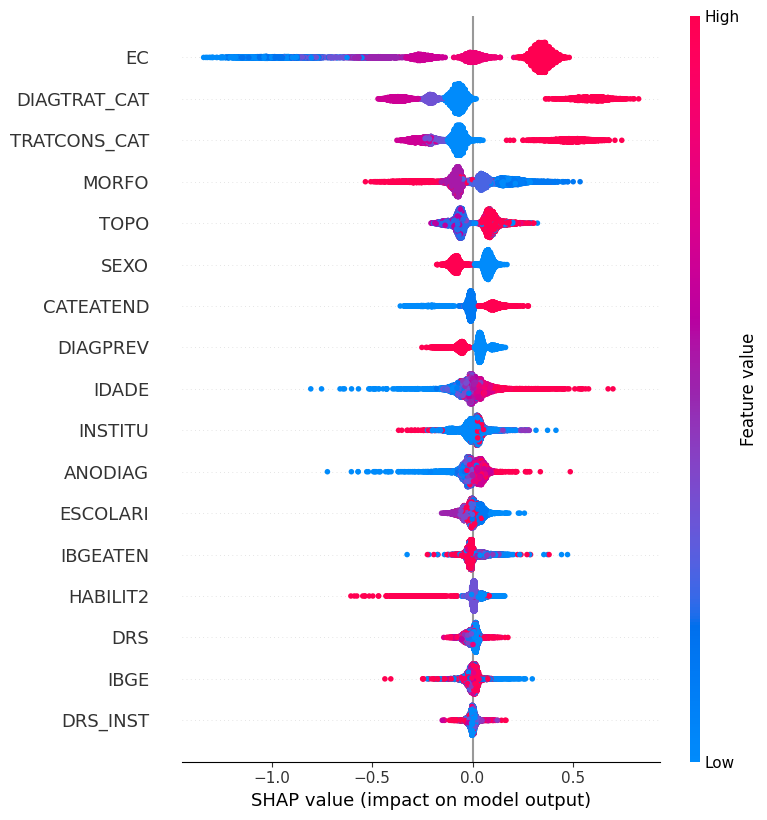

In [ ]:
# Best features by SHAP
explainer = shap.Explainer(best.predict, X_train, seed=seed,  # Create a SHAP explainer for the best model
                           output_names=feat_cols,  # Specify the feature names
                           n_jobs=-1)  # Use multiple jobs for parallel computation

shap_values = explainer(X_test)  # Calculate SHAP values for the test set

# Plot the SHAP summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

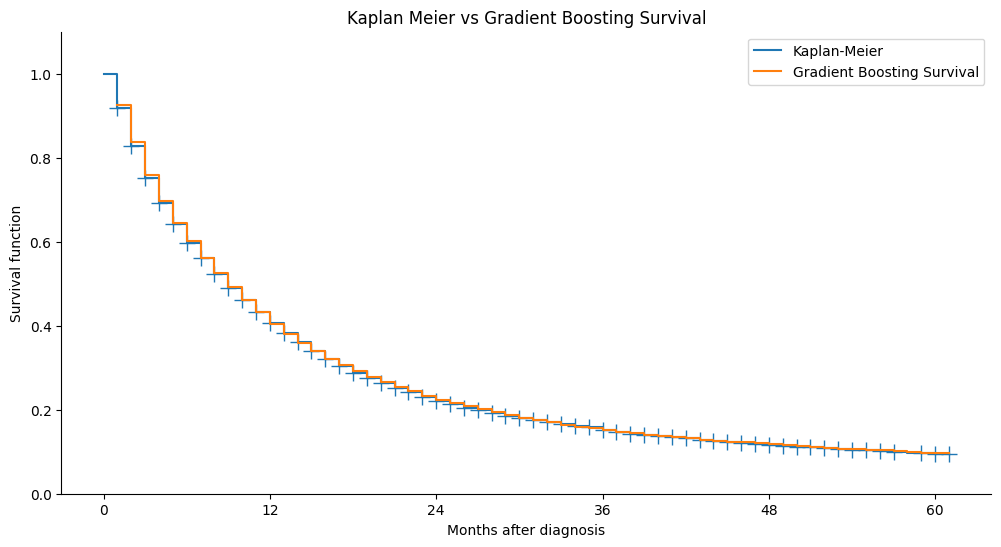

In [ ]:
# Comparison of survival curves
name = 'Gradient Boosting Survival'  # Set the name for the survival model

surv_gbs = best.predict_survival_function(X_test, return_array=True)  # Predict the survival function for the test set
surv_gbs_mean = surv_gbs.mean(axis=0)  # Compute the mean survival probability across the predictions

# Plot the survival curve and compare with the Kaplan-Meier curve
plot_survival_curve(best.unique_times_, surv_gbs_mean,
                    name=name, compare_km=True, test_df=df_teste)  # Visualize the survival curve with the comparison to the Kaplan-Meier estimate

### **Survival SVM**

#### **Base Model**

In [ ]:
# SurvivalSVM Model
ssvm = FastSurvivalSVM(random_state=seed)  # Initialize the FastSurvivalSVM model with a fixed random state

ssvm.fit(X_train, y_train)  # Train the model on the training data

c_index_base = ssvm.score(X_test, y_test)  # Calculate the C-index on the test dataset

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_base}')
print(f'C-Index Train: {ssvm.score(X_train, y_train)}')

C-Index Test: 0.6686054183992319
C-Index Train: 0.6702181187393438


In [ ]:
# C-Index IPCW
surv_risks = ssvm.predict(X_test)  # Predict survival risks for the test dataset
surv_risks_train = ssvm.predict(X_train)  # Predict survival risks for the training dataset

# Calculate the IPCW C-index for both test and training datasets
c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)

# Print the IPCW C-index for both test and training datasets
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')

C-Index IPCW Test: 0.666899029983097
C-Index IPCW Train: 0.6681115124879631


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(10, shuffle=True, random_state=seed)  # Create a KFold cross-validator with 10 splits, shuffling, and a fixed random seed

def c_index(estimator, X, y):
    cindex = estimator.score(X, y)  # Compute the C-index of the estimator on the dataset
    return cindex

def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'alpha': trial.suggest_categorical('alpha', [1e-3, 1e-2, 1e-1, 1, 10]),  # Suggest different values for the alpha regularization parameter
        'rank_ratio': trial.suggest_float('rank_ratio', 0.1, 1.0, step=0.05),  # Suggest a value for the rank ratio
        'tol': trial.suggest_categorical('tol', [1e-5, 1e-4, 1e-3, 1e-2]),  # Suggest tolerance values for convergence
    }

    # Train the model with the suggested parameters
    ssvm = FastSurvivalSVM(**param, random_state=seed)

    return cross_val_score(ssvm, X_train, y_train, cv=kf, scoring=c_index).mean()  # Return the mean cross-validated C-index score

**RandomSampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'opt_svm_rand.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create a new Optuna study
                                study_name='SSVM_RandomSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 15.5 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 0.001, 'rank_ratio': 0.55, 'tol': 0.01}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_rand = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_rand.fit(X_train, y_train)  # Train the model on the training data

c_index_rand = ssvm_rand.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {ssvm_rand.score(X_train, y_train)}')

C-Index Test: 0.6686458738427932
C-Index Train: 0.6702855676607182


**TPESampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'opt_svm_tpe.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create a new Optuna study using TPE sampler
                                study_name='SSVM_TPESampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 21.3 ms, sys: 1e+03 ns, total: 21.3 ms
Wall time: 21.8 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 1, 'rank_ratio': 0.1, 'tol': 0.01}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_tpe = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_tpe.fit(X_train, y_train)  # Train the model on the training data

c_index_tpe = ssvm_tpe.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {ssvm_tpe.score(X_train, y_train)}')

C-Index Test: 0.6686457936536088
C-Index Train: 0.67028422623772


**CmaEsSampler**

In [ ]:
%%time
# Filename for saving the pickle study
pickle_filename = 'opt_svm_cma.pkl'

# Load the existing study or create a new one
if os.path.exists(pickle_filename):
    with open(pickle_filename, 'rb') as f:
        study = pickle.load(f)  # Load the study from the pickle file if it exists
else:
    study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create a new Optuna study using CMA-ES sampler
                                study_name='SSVM_CmaEsSampler')

# Total number of desired trials
completed_trials = len(study.trials)

# Execute remaining trials in blocks
while completed_trials < n_trials:
    study.optimize(objective, n_trials=50, n_jobs=-1)  # Optimize the objective function with 50 trials at a time
    completed_trials = len(study.trials)
    print(f"\nCompleted trials: {completed_trials}/{n_trials}")

    # Save the study after each block
    with open(pickle_filename, 'wb') as f:
        pickle.dump(study, f)  # Save the study object to a pickle file

CPU times: user 22.6 ms, sys: 0 ns, total: 22.6 ms
Wall time: 23.6 ms


In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'alpha': 0.001, 'rank_ratio': 0.55, 'tol': 0.01}


In [ ]:
# Training and metrics with the best hyperparameters
best_params = study.best_params
ssvm_cma = FastSurvivalSVM(**best_params, random_state=seed)  # Initialize the model with the best parameters
ssvm_cma.fit(X_train, y_train)  # Train the model on the training data

c_index_cma = ssvm_cma.score(X_test, y_test)  # Compute the C-index on the test data

# Print the C-index for both test and training datasets
print(f'C-Index Test: {c_index_cma}')
print(f'C-Index Train: {ssvm_cma.score(X_train, y_train)}')

C-Index Test: 0.6686458738427932
C-Index Train: 0.6702855676607182


#### **Best Survival SVM Model**

In [ ]:
# Best SSVM model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for different models
models = [ssvm, ssvm_rand, ssvm_tpe, ssvm_cma]  # List of corresponding SSVM models

id_best_score = scores.index(max(scores))  # Identify the index of the model with the highest C-index score
best = models[id_best_score]  # Select the model with the best performance

print(best)  # Print the best model

FastSurvivalSVM(alpha=0.001, optimizer='avltree', random_state=1,
                rank_ratio=0.55, tol=0.01)


In [ ]:
# C-Index Calculation
print('C-Index')
print(f'> Test: {best.score(X_test, y_test)}')  # Calculate and print the C-index for the test set
print(f'> Train: {best.score(X_train, y_train)}')  # Calculate and print the C-index for the training set

# C-Index IPCW Calculation
surv_risks = best.predict(X_test)  # Predict survival risks for the test set
surv_risks_train = best.predict(X_train)  # Predict survival risks for the training set

# Compute IPCW C-index for test and train sets
c_index_ipcw = concordance_index_ipcw(y_train, y_test, -surv_risks)  # IPCW C-index for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, -surv_risks_train)  # IPCW C-index for the train set

print('\nC-Index IPCW')
print(f'> Test: {c_index_ipcw[0]}')  # Print the IPCW C-index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print the IPCW C-index for the training set

C-Index
> Test: 0.6686458738427932
> Train: 0.6702855676607182

C-Index IPCW
> Test: 0.666931663831022
> Train: 0.6681670822250786


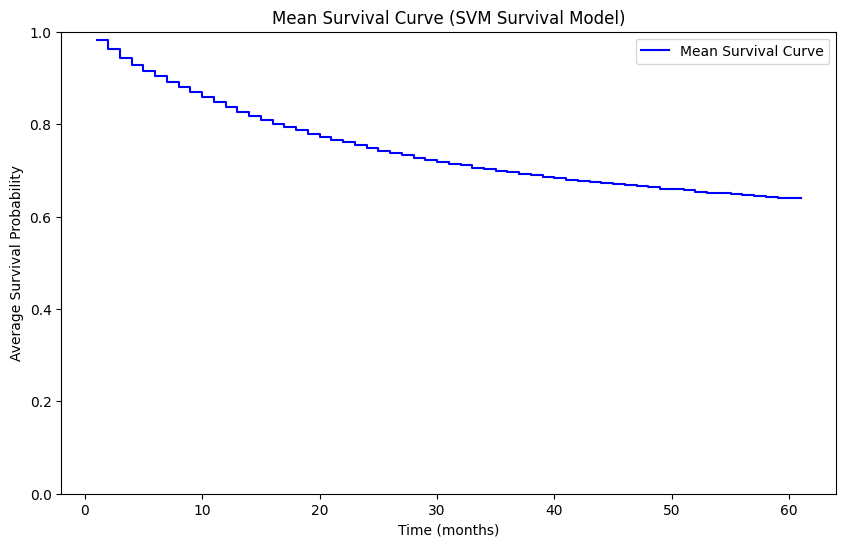

In [ ]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (SVM Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at 12 months: 0.4677
Brier Score at 36 months: 0.4913
Brier Score at 60 months: 0.4483

Integrated Brier Score (IBS): 0.4551


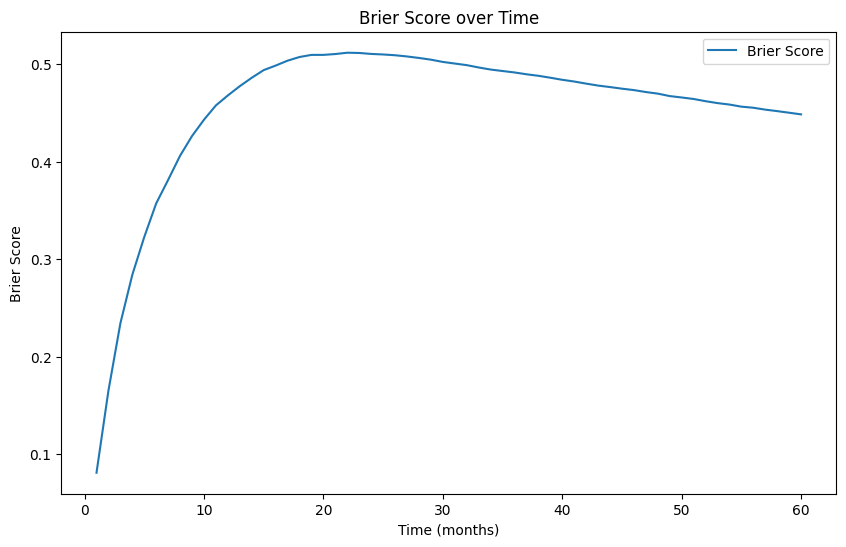

In [ ]:
# Time points for the calculation
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure alignment of survival probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)

# Adjust probabilities for the desired time points (row by row)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])
    for i in range(survival_probabilities.shape[0])
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the index of the closest time in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]

    # Get the actual observations
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for time t
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numeric value

    print(f"Brier Score at {t} months: {brier[1][0]:.4f}")

# Calculate the Brier Score over time for the IBS
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS)
time_differences = np.diff(np.hstack([[0], time_points]))
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, brier_scores[1], label="Brier Score")
plt.xlabel("Time (months)")
plt.ylabel("Brier Score")
plt.title("Brier Score over Time")
plt.legend()
plt.show()

In [ ]:
# Best features by permutation importance
calculate_permutation_importance(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
ANODIAG,5.457542e-05,0.000022
DRS_INST,8.606972e-07,0.000037
INSTITU,-8.390462e-06,0.000038
HABILIT2,-3.451610e-05,0.000210
ESCOLARI,-5.170064e-05,0.000024
IBGE,-9.226568e-05,0.000121
DRS,-1.690455e-04,0.000127
IDADE,-1.483961e-03,0.000428
IBGEATEN,-1.632300e-03,0.000414
SEXO,-3.821385e-03,0.000706


PermutationExplainer explainer: 9145it [02:41, 54.36it/s]                          


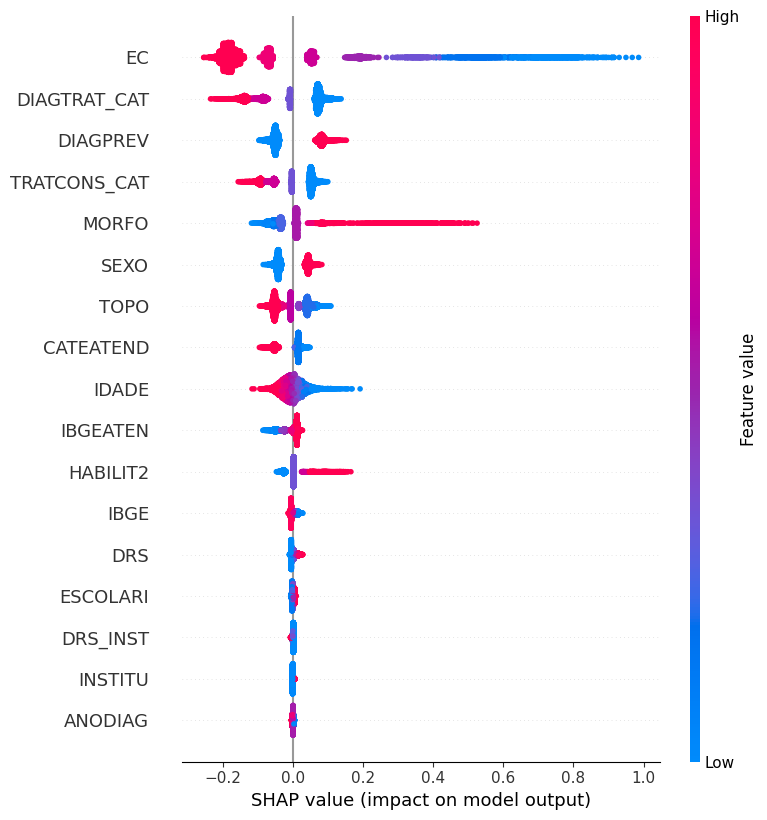

In [ ]:
# Best features by SHAP
explainer = shap.Explainer(best.predict, X_train, seed=seed,  # Create a SHAP explainer for the best model
                           output_names=feat_cols,  # Specify the feature names
                           n_jobs=-1)  # Use multiple jobs for parallel computation

shap_values = explainer(X_test)  # Calculate SHAP values for the test set

# Plot the SHAP summary plot to visualize feature importance
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

### **XGBoost**

#### **Base Model**

In [ ]:
# XGBoost Model
weights = np.where(y_train['event'], 1.0, 0.25)  # Assigning weights to the training data based on event status (1.0 for events, 0.15 for censored)

dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # Prepare the training dataset for XGBoost, including weights and time as the target
dtest = xgb.DMatrix(X_test)  # Prepare the test dataset for prediction

# Training the XGBoost model for survival analysis
params = {
    'objective': 'survival:cox',  # Specify Cox proportional hazards objective for survival analysis
    'eval_metric': 'cox-nloglik',  # Use negative log-likelihood as the evaluation metric
    'max_depth': 3,  # Set the maximum depth of trees
    'seed': seed,  # Set random seed for reproducibility
}
xgboost = xgb.train(params, dtrain, num_boost_round=100)  # Train the XGBoost model with 100 boosting rounds

# Make predictions and calculate C-Index for Test data
y_pred = xgboost.predict(dtest)  # Predict survival times for the test set
c_index_base = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # Calculate C-Index for the test data

# Make predictions and calculate C-Index for Training data
y_pred_train = xgboost.predict(dtrain)  # Predict survival times for the training set
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # Calculate C-Index for the training data

# Display C-Index for Test and Train data
print(f'C-index Test: {c_index_base}')  # Print the C-Index for the test data
print(f'C-index Train: {c_index_train}')  # Print the C-Index for the training data

C-index Test: 0.7201870979397822
C-index Train: 0.7341467667233496


In [ ]:
# C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = xgboost.predict(dtest)  # Predict the survival risks for the test set
surv_risks_train = xgboost.predict(dtrain)  # Predict the survival risks for the training set

# Calculate the C-Index IPCW for Test and Train data
c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)  # Compute the C-Index IPCW for the test data
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)  # Compute the C-Index IPCW for the training data

# Display C-Index IPCW for Test and Train data
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')  # Print the C-Index IPCW for the test data
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')  # Print the C-Index IPCW for the training data

C-Index IPCW Test: 0.7163373487259056
C-Index IPCW Train: 0.7297839179001187


#### **Optuna**

In [ ]:
# Optuna number o trials
n_trials = 150

In [ ]:
# Folds for Cross-Validation
kf = KFold(10, shuffle=True, random_state=seed)  # Create 10-fold cross-validation with shuffling
c_index_list = []  # List to store the C-index values from each fold

def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),  # Number of estimators (trees)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25, step=0.01),  # Learning rate
        'max_depth': trial.suggest_int('max_depth', 2, 4),  # Maximum depth of trees
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Minimum weight of child nodes
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),  # Fraction of data used for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),  # Fraction of features used per tree
        'reg_alpha': trial.suggest_categorical('reg_alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),  # L1 regularization term
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),  # L2 regularization term
        'objective': 'survival:cox',  # Cox loss function for survival analysis
        'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
        'random_state': seed,  # Seed for reproducibility
        'n_jobs': -1,  # Use all available cores for training
    }

    # Loop over the folds in cross-validation
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data into training and validation sets for the current fold
        X_t, X_v = X_train[train_idx], X_train[valid_idx]  # Split features
        y_t, y_v = y_train[train_idx], y_train[valid_idx]  # Split labels

        # Create DMatrix for training and validation (DMatrix is an optimized data structure for XGBoost)
        dtrain = xgb.DMatrix(X_t, label=y_t['time'], weight=np.where(y_t['event'], 1.0, 0.25))  # Set event weights
        dvalid = xgb.DMatrix(X_v)  # Validation DMatrix (no labels, predictions will be made)

        # Train the XGBoost model using the specified hyperparameters
        model = xgb.train(param, dtrain, num_boost_round=100, verbose_eval=False)  # Train model with 100 boosting rounds

        # Make predictions on the validation set
        pred_valid = model.predict(dvalid)

        # Calculate the Concordance Index (C-Index) for the validation fold
        c_index = concordance_index_censored(y_v['event'], y_v['time'], pred_valid)[0]
        c_index_list.append(c_index)  # Append the C-Index for this fold to the list

    # Return the average C-Index across all folds
    return np.mean(c_index_list)  # The objective function returns the mean C-Index from the cross-validation folds

**RandomSampler**

In [ ]:
# Hyperparameter optimization with Optuna - RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create a study to maximize the objective function
                            study_name='XGB_RandomSampler')  # Study name

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run the optimization with 'n_trials' trials in parallel

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 86, 'learning_rate': 0.06999999999999999, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 1.0, 'colsample_bytree': 0.55, 'reg_alpha': 0.001, 'reg_lambda': 0.0001}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.15 for non-event)

best_params = study.best_params  # Get the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_rand = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_rand.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_rand.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_rand = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_rand_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_rand}')  # C-Index for the test set
print(f'C-Index Train: {c_index_rand_train}')  # C-Index for the training set

C-Index Test: 0.7202539623547597
C-Index Train: 0.7303607687199253


**TPESampler**

In [ ]:
# Hyperparameter optimization with Optuna - TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create a study with TPE sampler for optimization
                            study_name='XGB_TPESampler')  # Study name for identification

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run optimization for 'n_trials' trials using parallel processing

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 65, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.55, 'colsample_bytree': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.0001}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.15 for non-event)
best_params = study.best_params  # Retrieve the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_tpe = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_tpe.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_tpe.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_tpe = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_tpe_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_tpe}')  # C-Index for the test set
print(f'C-Index Train: {c_index_tpe_train}')  # C-Index for the training set

C-Index Test: 0.720117867943863
C-Index Train: 0.7316122144124436


**CmaEsSampler**

In [ ]:
# Hyperparameter optimization with Optuna - CmaEsSampler
study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create a study with CMA-ES sampler for optimization
                            study_name='XGB_CmaEsSampler')  # Study name for identification

study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Run optimization for 'n_trials' trials using parallel processing

In [ ]:
# Display the best hyperparameters found
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 104, 'learning_rate': 0.060000000000000005, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.65, 'reg_alpha': 0.001, 'reg_lambda': 0.01}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.25)  # Assign higher weights to events (1.0 for event and 0.15 for non-event)
best_params = study.best_params  # Retrieve the best parameters from the study
best_params.update({'objective': 'survival:cox',  # Cox loss function for survival analysis
                    'eval_metric': 'cox-nloglik',  # Evaluation metric for Cox model
                    'random_state': seed,  # Set the random seed for reproducibility
                    'n_jobs': -1})  # Use all available cores for training

# Prepare the DMatrix objects for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train['time'], weight=weights)  # DMatrix for training with weights
dtest = xgb.DMatrix(X_test)  # DMatrix for testing without labels

# Train the XGBoost model with the best parameters
xgb_cma = xgb.train(best_params, dtrain, num_boost_round=100, verbose_eval=False,
                    # evals=[(dtest, "validation")],  # Optional: Evaluate on validation data
                    # early_stopping_rounds=10       # Optional: Stop training after 10 rounds without improvement
                    )

# Make predictions on the test and training datasets
y_pred = xgb_cma.predict(dtest)  # Predictions on the test data
y_pred_train = xgb_cma.predict(dtrain)  # Predictions on the training data

# Calculate the Concordance Index (C-Index) for test and training predictions
c_index_cma = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for test
c_index_cma_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for train

# Print the C-Index values
print(f'C-Index Test: {c_index_cma}')  # C-Index for the test set
print(f'C-Index Train: {c_index_cma_train}')  # C-Index for the training set

C-Index Test: 0.719750708397938
C-Index Train: 0.7293855533644087


#### **Best XGBoost Model**

In [ ]:
# Best XGBoost model
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-index scores for each model
models = [xgboost, xgb_rand, xgb_tpe, xgb_cma]  # List of the trained models

# Find the model with the highest C-index
id_best_score = scores.index(max(scores))  # Get the index of the model with the best score
best = models[id_best_score]  # Select the best model based on the highest C-index

print(best)  # Display the best model

In [17]:
# Make predictions on the validation and training sets
y_pred = best.predict(dtest)  # Predictions on the test set
y_pred_train = best.predict(dtrain)  # Predictions on the training set

# Calculate the C-Index for the test and training sets
final_c_index = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]  # C-Index for the test set
final_c_index_train = concordance_index_censored(y_train['event'], y_train['time'], y_pred_train)[0]  # C-Index for the training set

print('C-Index')  # Print label for C-Index
print(f'> Test: {final_c_index}')  # Print C-Index for the test set
print(f'> Train: {final_c_index_train}')  # Print C-Index for the training set

# Calculate the C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = best.predict(dtest)  # Survival risks for the test set
surv_risks_train = best.predict(dtrain)  # Survival risks for the training set

c_index_ipcw = concordance_index_ipcw(y_train, y_test, surv_risks)  # C-Index IPCW for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, surv_risks_train)  # C-Index IPCW for the training set

print('\nC-Index IPCW')  # Print label for C-Index IPCW
print(f'> Test: {c_index_ipcw[0]}')  # Print IPCW C-Index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print IPCW C-Index for the training set

C-Index
> Test: 0.7202539623547597
> Train: 0.7303607687199253

C-Index IPCW
> Test: 0.7163902637418212
> Train: 0.7260814214610259


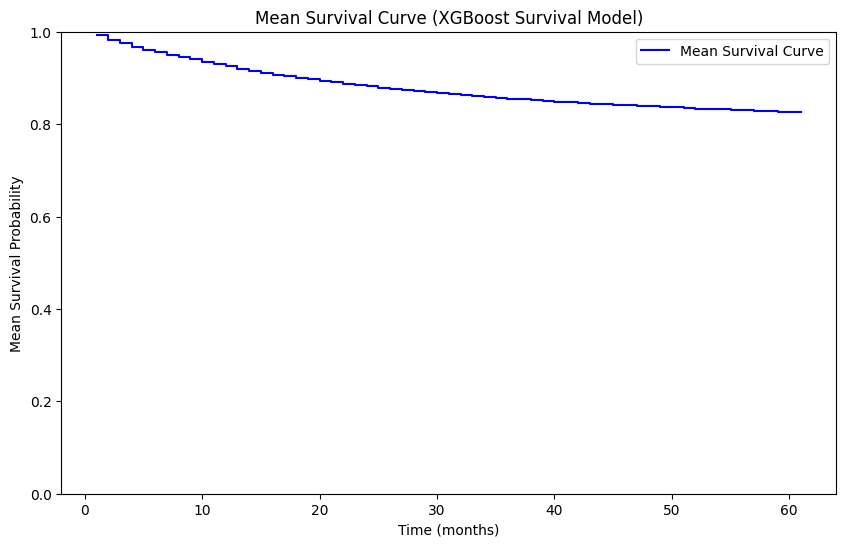

In [19]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (XGBoost Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at time 12 months: 0.4909
Brier Score at time 36 months: 0.6237
Brier Score at time 60 months: 0.6341

Integrated Brier Score (IBS): 0.5558


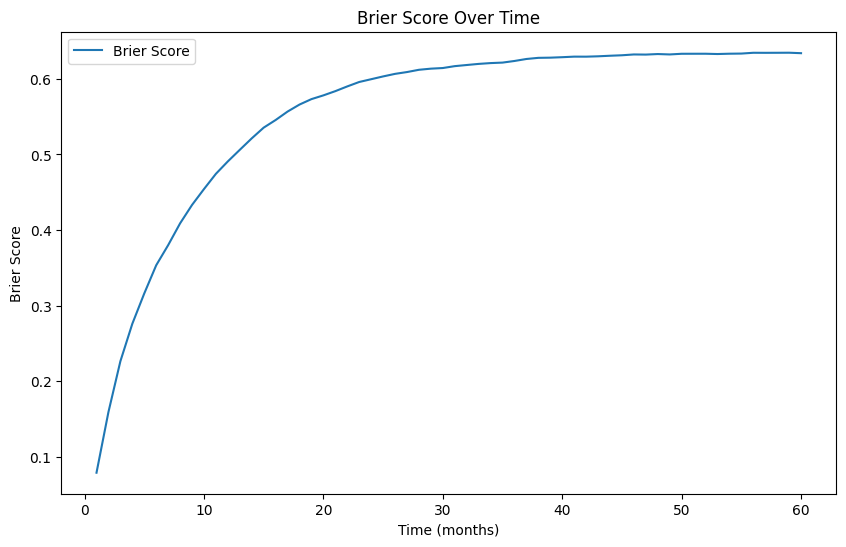

In [ ]:
# Define time points for the calculation (1 to 60 months)
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure alignment of survival probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)

# Adjust the survival probabilities to the desired time points (row by row)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])  # Interpolate the survival probabilities
    for i in range(survival_probabilities.shape[0])
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the index of the closest time point in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]

    # Get the actual observations (whether the event occurred at or after time 't')
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for the time 't'
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numeric value

    print(f"Brier Score at time {t} months: {brier[1][0]:.4f}")

# Calculate the Brier Score over time for the Integrated Brier Score (IBS)
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS)
time_differences = np.diff(np.hstack([[0], time_points]))  # Time differences between consecutive time points
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]  # Calculate the IBS
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, brier_scores[1], label="Brier Score")  # Plot Brier Score across time points
plt.xlabel("Time (months)")
plt.ylabel("Brier Score")
plt.title("Brier Score Over Time")
plt.legend()
plt.show()

In [ ]:
# Best features by permutation importance
calculate_permutation_importance_xgb(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.060149,0.002241
TRATCONS_CAT,0.046736,0.001282
DIAGTRAT_CAT,0.029761,0.000600
MORFO,0.008037,0.000758
TOPO,0.004695,0.000398
DIAGPREV,0.003829,0.000426
ANODIAG,0.003635,0.001389
CATEATEND,0.003155,0.000414
SEXO,0.002981,0.000458
INSTITU,0.002389,0.000400


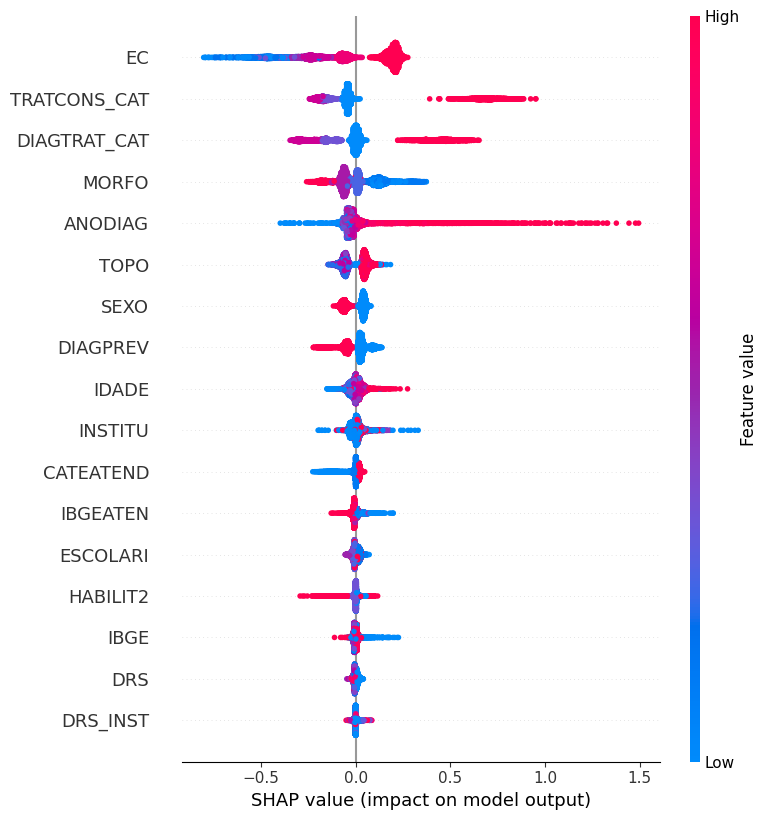

In [ ]:
# Create a SHAP TreeExplainer for the best model
explainer = shap.TreeExplainer(best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Generate a summary plot to visualize the SHAP values for each feature
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)

### **LightGBM**

#### **Base Model**

In [ ]:
# LightGBM Model
dtrain = lgb.Dataset(X_train, label=y_train['time'],
                     weight=np.where(y_train['event'], 1.0, 0.15))  # Create a LightGBM dataset with event weights

# Define model parameters
params = {
    'objective': 'regression',  # LightGBM does not have direct survival support, using regression as a proxy
    'metric': 'rmse',           # Metric for monitoring (not used for survival analysis)
    'max_depth': 3,             # Maximum depth of trees
    'seed': seed,               # Set random seed for reproducibility
    'verbose': -1,              # Suppress output during training
    'n_jobs': -1                # Use all CPU cores for training
}

# Train the model
lgbm = lgb.train(params, dtrain, num_boost_round=100)  # Train the LightGBM model with 100 boosting rounds

# Make predictions (risk scores)
y_pred = lgbm.predict(X_test)  # Predict risk scores on the test data

# Evaluate the model using the C-Index (Test data)
c_index_base = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]  # Calculate C-Index for test data

# Evaluate the model using the C-Index (Train data)
y_pred_train = lgbm.predict(X_train)  # Predict risk scores on the training data
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]  # Calculate C-Index for training data

# Display the results
print(f'C-index Test: {c_index_base}')  # Print the C-Index for test data
print(f'C-index Train: {c_index_train}')  # Print the C-Index for train data

C-index Test: 0.7205780870383566
C-index Train: 0.7280705568170978


In [ ]:
# C-Index IPCW (Inverse Probability of Censoring Weight)
surv_risks = lgbm.predict(X_test)  # Predict survival risks for the test data
surv_risks_train = lgbm.predict(X_train)  # Predict survival risks for the training data

# Calculate the C-Index using IPCW for test data
c_index_ipcw = concordance_index_ipcw(y_train, y_test, -surv_risks)  # Evaluate the concordance index for test data

# Calculate the C-Index using IPCW for training data
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, -surv_risks_train)  # Evaluate the concordance index for training data

# Display the results for C-Index IPCW
print(f'C-Index IPCW Test: {c_index_ipcw[0]}')  # Print the IPCW C-Index for test data
print(f'C-Index IPCW Train: {c_index_ipcw_train[0]}')  # Print the IPCW C-Index for train data

C-Index IPCW Test: 0.7167196122832462
C-Index IPCW Train: 0.7238666603406112


#### **Optuna**

In [ ]:
# Optuna number of trials
n_trials = 150

In [ ]:
# Folds for cross-validation
kf = KFold(10, shuffle=True, random_state=seed)  # Split the data into 10 folds, shuffle data and set a random seed
c_index_list = []  # Initialize an empty list to store the C-Index scores for each fold

# Objective function for hyperparameter optimization
def objective(trial):
    # Define the hyperparameters to be optimized
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),  # Number of trees in the model
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25, step=0.01),  # Learning rate for boosting
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Maximum depth of the trees
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # Number of leaves in each tree
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),  # Minimum samples for each child node
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),  # Subsample ratio for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),  # Column sampling ratio for each tree
        'reg_alpha': trial.suggest_categorical('reg_alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10.0]),  # L1 regularization term
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1e-4, 1e-3, 1e-2, 1e-1, 1, 10.0]),  # L2 regularization term
        'objective': 'regression',  # Set objective to regression (using Cox regression as a proxy)
        'metric': 'rmse',  # Metric for evaluation (Root Mean Squared Error)
        'seed': seed,  # Random seed
        'verbose': -1,  # Suppress output during training
        'n_jobs': -1  # Use all available CPU cores for parallel computation
    }
    # Loop through the folds for cross-validation
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data into training and validation sets based on the current fold
        X_t, X_v = X_train[train_idx], X_train[valid_idx]  # Training and validation features
        y_t, y_v = y_train[train_idx], y_train[valid_idx]  # Training and validation target labels

        # Create DMatrix for training data, using weights based on event occurrence
        dtrain = lgb.Dataset(X_t, label=y_t['time'], weight=np.where(y_t['event'], 1.0, 0.15))

        # Train the model using the current hyperparameters
        model = lgb.train(params, dtrain, num_boost_round=100)

        # Make predictions on the validation set
        pred_valid = model.predict(X_v)

        # Calculate the Concordance Index for the validation fold
        c_index = concordance_index_censored(y_v['event'], y_v['time'], -pred_valid)[0]
        c_index_list.append(c_index)  # Append the C-Index score to the list

    # Return the mean C-Index across all folds
    return np.mean(c_index_list)

**RandomSampler**

In [ ]:
# Hyperparameter optimization with Optuna - RandomSampler
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed),  # Create an Optuna study with a random sampler for optimization
                            study_name='LGBM_RandomSampler')  # Name the study for identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using a random sampler

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 107, 'learning_rate': 0.060000000000000005, 'max_depth': 5, 'num_leaves': 49, 'min_child_samples': 18, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 10.0, 'reg_lambda': 0.1}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the required model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Use regression (Cox model) for survival analysis
                    'metric': 'rmse',  # Metric for monitoring performance (Root Mean Squared Error)
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing if needed, but it's not used here

# Train the LightGBM model with the best parameters found by Optuna
lgbm_rand = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on the validation and training sets
y_pred = lgbm_rand.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_rand.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_rand = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_rand_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both test and training sets
print(f'C-Index Test: {c_index_rand}')
print(f'C-Index Train: {c_index_rand_train}')

C-Index Test: 0.7210653031582858
C-Index Train: 0.7333145696254425


**TPESampler**

In [ ]:
# Hyperparameter optimization with Optuna - TPESampler
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed),  # Create an Optuna study using the TPE sampler for optimization
                            study_name='LGBM_TPESampler')  # Name the study for easier identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using TPE with specified trials and parallel jobs

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 112, 'learning_rate': 0.11, 'max_depth': 3, 'num_leaves': 49, 'min_child_samples': 19, 'subsample': 0.65, 'colsample_bytree': 0.9, 'reg_alpha': 0.01, 'reg_lambda': 1}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the necessary model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Using Cox regression for survival analysis
                    'metric': 'rmse',  # Root Mean Squared Error metric for monitoring performance
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing, but it's not utilized in the current context

# Train the LightGBM model with the best parameters found by Optuna
lgbm_tpe = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on both the validation and training sets
y_pred = lgbm_tpe.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_tpe.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_tpe = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_tpe_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both the test and training sets
print(f'C-Index Test: {c_index_tpe}')
print(f'C-Index Train: {c_index_tpe_train}')

C-Index Test: 0.7205882977945114
C-Index Train: 0.7286747086621894


**CmaEsSampler**

In [ ]:
# Hyperparameter optimization with Optuna - CmaEsSampler
study = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed),  # Create an Optuna study using the CMA-ES sampler for optimization
                            study_name='LGBM_CmaEsSampler')  # Name the study for easier identification
study.optimize(objective, n_trials=n_trials, n_jobs=-1)  # Optimize the objective function using CMA-ES with specified trials and parallel jobs

In [ ]:
# Display the best hyperparameters found by Optuna
print('Best parameters:', study.best_params)

Best parameters: {'n_estimators': 67, 'learning_rate': 0.09, 'max_depth': 3, 'num_leaves': 67, 'min_child_samples': 11, 'subsample': 0.95, 'colsample_bytree': 0.55, 'reg_alpha': 10.0, 'reg_lambda': 1}


In [ ]:
# Training and evaluation with the best hyperparameters
weights = np.where(y_train['event'], 1.0, 0.15)  # Assign weights based on event occurrence (1.0 for events, 0.15 for censored data)

# Update the best parameters with the necessary model settings
best_params = study.best_params
best_params.update({'objective': 'regression',  # Using Cox regression for survival analysis
                    'metric': 'rmse',  # Root Mean Squared Error metric for monitoring performance
                    'seed': seed,  # Set the random seed for reproducibility
                    'verbose': -1,  # Suppress output during training
                    'n_jobs': -1})  # Use all available CPU cores for parallel computation

# Create the LightGBM dataset using the training data and weights
dtrain = lgb.Dataset(X_train, label=y_train['time'], weight=weights)
# dtest = xgb.DMatrix(X_test)  # You could use this for testing, but it's not utilized in the current context

# Train the LightGBM model with the best parameters found by Optuna
lgbm_cma = lgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on both the validation and training sets
y_pred = lgbm_cma.predict(X_test)  # Predictions for the test set
y_pred_train = lgbm_cma.predict(X_train)  # Predictions for the training set

# Calculate the Concordance Index (C-Index) for the test set
c_index_cma = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]
c_index_cma_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]

# Display the C-Index for both the test and training sets
print(f'C-Index Test: {c_index_cma}')
print(f'C-Index Train: {c_index_cma_train}')

C-Index Test: 0.7194351505922145
C-Index Train: 0.7263797069181139


#### **Best LightGBM Model**

In [ ]:
# Best LightGBM Model Selection
scores = [c_index_base, c_index_rand, c_index_tpe, c_index_cma]  # List of C-Index scores for each model (base, random, TPE, CMA-ES)
models = [lgbm, lgbm_rand, lgbm_tpe, lgbm_cma]  # List of LightGBM models corresponding to each hyperparameter optimization approach

# Identify the model with the highest C-Index score
id_best_score = scores.index(max(scores))  # Find the index of the highest C-Index score
best = models[id_best_score]  # Select the model corresponding to the best score

# Display the best model
print(best)

In [21]:
# Make predictions on the validation and training sets
y_pred = best.predict(X_test)  # Predict survival risks on the test set using the best model
y_pred_train = best.predict(X_train)  # Predict survival risks on the training set using the best model

# Calculate C-Index for the test set
final_c_index = concordance_index_censored(y_test['event'], y_test['time'], -y_pred)[0]  # Compute the concordance index for the test set
final_c_index_train = concordance_index_censored(y_train['event'], y_train['time'], -y_pred_train)[0]  # Compute the concordance index for the training set

# Display C-Index results
print('C-Index')
print(f'> Test: {final_c_index}')  # Print the C-Index for the test set
print(f'> Train: {final_c_index_train}')  # Print the C-Index for the training set

# Calculate the C-Index with Inverse Probability of Censoring Weighting (IPCW)
surv_risks = best.predict(X_test)  # Get the survival risks (predictions) for the test set
surv_risks_train = best.predict(X_train)  # Get the survival risks (predictions) for the training set

# Calculate IPCW C-Index
c_index_ipcw = concordance_index_ipcw(y_train, y_test, -surv_risks)  # Compute IPCW C-Index for the test set
c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, -surv_risks_train)  # Compute IPCW C-Index for the training set

# Display IPCW C-Index results
print('\nC-Index IPCW')
print(f'> Test: {c_index_ipcw[0]}')  # Print IPCW C-Index for the test set
print(f'> Train: {c_index_ipcw_train[0]}')  # Print IPCW C-Index for the training set

C-Index
> Test: 0.7210653031582858
> Train: 0.7333145696254425

C-Index IPCW
> Test: 0.7172562030524626
> Train: 0.7290278316993352


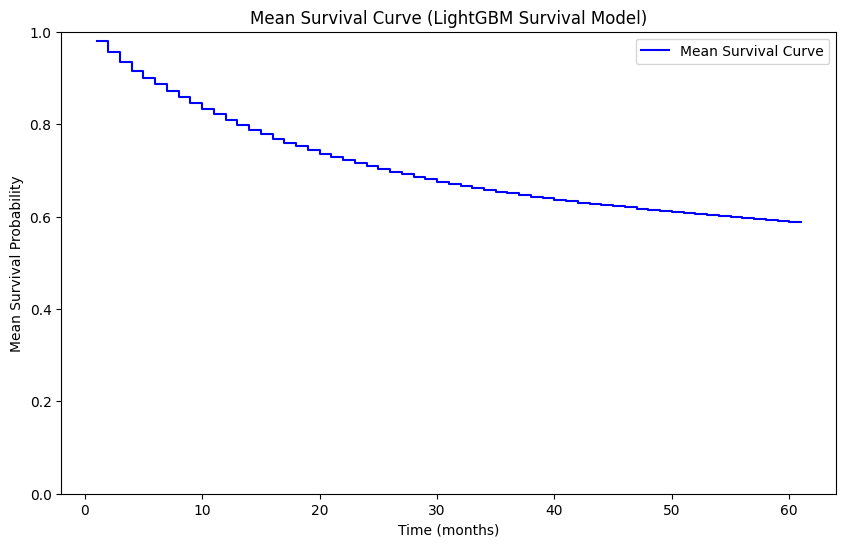

In [23]:
# Normalize the survival risks (scale them between 0 and 1)
surv_risks_normalized = (surv_risks - np.min(surv_risks)) / (np.max(surv_risks) - np.min(surv_risks))

# Estimate the baseline survival function using Kaplan-Meier on the training data
time, survival_prob = kaplan_meier_estimator(y_train["event"], y_train["time"])

# Calculate the survival probabilities for all individuals
survival_probabilities = predict_survival_probability(surv_risks_normalized, survival_prob, time)

# Calculate the mean survival probability across all individuals
mean_survival_probability = survival_probabilities.mean(axis=0)  # Now (n_time,)

# Plot the mean survival curve
plt.figure(figsize=(10, 6))
plt.step(time, mean_survival_probability, where="post", color="blue", label="Mean Survival Curve")

# Configure the plot
plt.title("Mean Survival Curve (LightGBM Survival Model)")
plt.xlabel("Time (months)")
plt.ylabel("Mean Survival Probability")
plt.ylim([0, 1.0])  # Set y-axis limit to 0-1
plt.legend()
plt.show()

Brier Score at 12 months: 0.4591
Brier Score at 36 months: 0.4499
Brier Score at 60 months: 0.3975

Integrated Brier Score (IBS): 0.4245


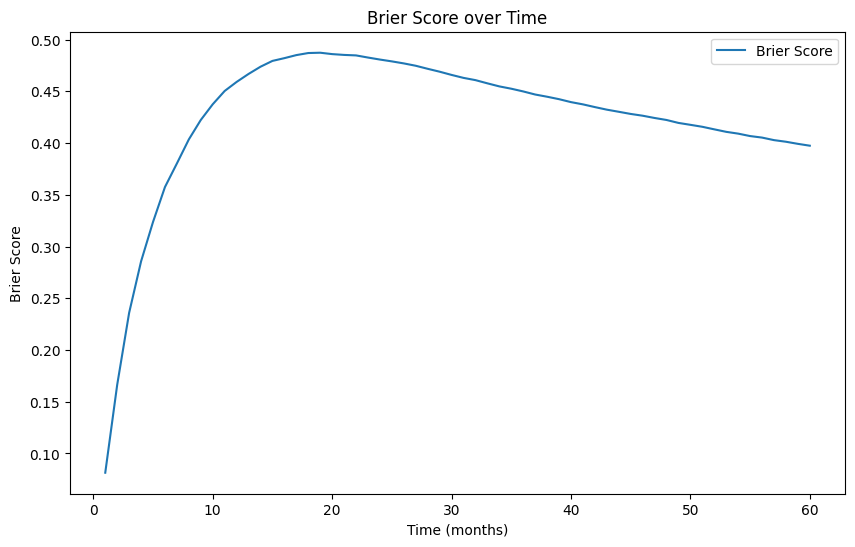

In [24]:
# Define the time points for calculation, from 1 to 60 months
time_points = np.arange(1, 61, 1)  # From 1 to 60 months
specific_time_points = [12, 36, 60]  # Specific time points for analysis

# Ensure the alignment of survival_probabilities with 'time'
assert survival_probabilities.shape[1] == len(time)  # Check that the number of time points matches

# Interpolate the survival probabilities to match the desired time points (line by line)
surv_curves = np.array([
    np.interp(time_points, time, survival_probabilities[i, :])  # Interpolate survival probabilities for each individual
    for i in range(survival_probabilities.shape[0])  # Loop over each individual
])

# Calculate the Brier Score at specific time points
brier_scores_specific = []
for t in specific_time_points:
    # Find the closest time index in 'time_points'
    idx = np.abs(time_points - t).argmin()
    prob_surv_t = surv_curves[:, idx]  # Get the survival probabilities at the specified time point

    # Obtain the true values based on the actual event and time
    true_values = (y_test['time'] >= t) & (y_test['event'] == 1)

    # Calculate the Brier Score for the given time point t
    brier = brier_score(y_train, y_test, prob_surv_t, [t])
    brier_scores_specific.append(brier[1][0])  # Extract the numerical Brier Score value

    print(f"Brier Score at {t} months: {brier[1][0]:.4f}")  # Print the Brier Score at the specific time point

# Calculate the Brier Score over the entire time range for the Integrated Brier Score (IBS)
brier_scores = brier_score(y_train, y_test, surv_curves, time_points)

# Calculate the Integrated Brier Score (IBS) by summing the weighted Brier Scores over time
time_differences = np.diff(np.hstack([[0], time_points]))  # Compute time differences between consecutive time points
ibs = np.sum(brier_scores[1] * time_differences) / time_points[-1]  # Calculate IBS
print(f"\nIntegrated Brier Score (IBS): {ibs:.4f}")  # Print the Integrated Brier Score

# Plot the Brier Score over time
plt.figure(figsize=(10, 6))  # Create a figure with the specified size
plt.plot(time_points, brier_scores[1], label="Brier Score")  # Plot Brier Score over time
plt.xlabel("Time (months)")  # Label the x-axis
plt.ylabel("Brier Score")  # Label the y-axis
plt.title("Brier Score over Time")  # Set the plot title
plt.legend()  # Add a legend to the plot
plt.show()  # Display the plot

In [ ]:
# Best features by permutation importance
calculate_permutation_importance_lgbm(best, X_test, y_test, feat_cols, random_state=seed)  # Calculate permutation importance of features for the best model

,importances_mean,importances_std
EC,0.066062,0.002620
TRATCONS_CAT,0.057915,0.001274
DIAGTRAT_CAT,0.028074,0.000937
MORFO,0.008346,0.001121
TOPO,0.003938,0.000261
ANODIAG,0.003747,0.001376
CATEATEND,0.003659,0.000493
DIAGPREV,0.003103,0.000374
INSTITU,0.002950,0.000209
SEXO,0.002835,0.000475


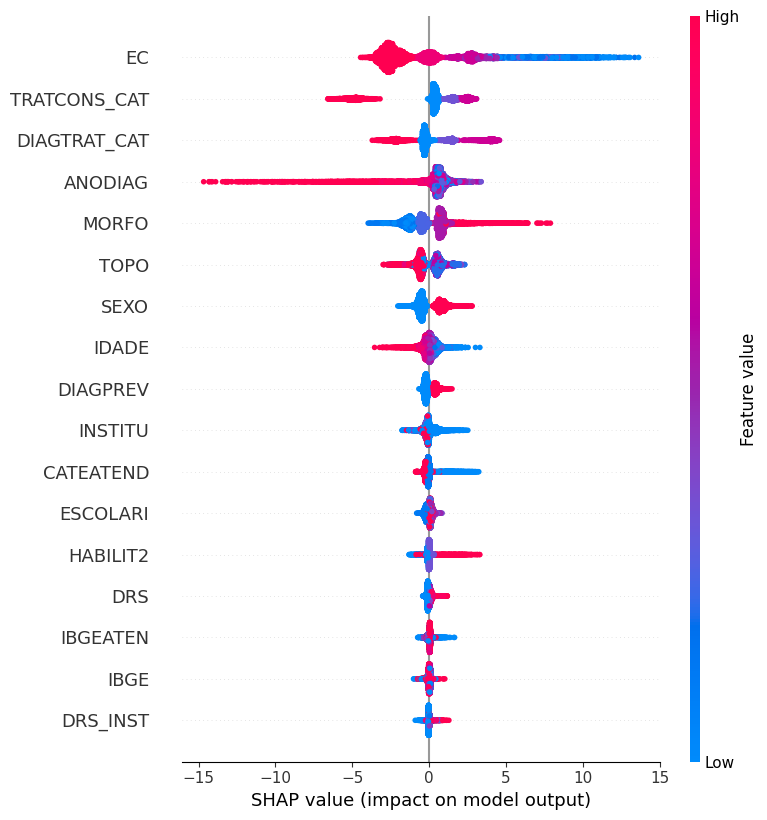

In [ ]:
# Create a SHAP TreeExplainer for the best model
explainer = shap.TreeExplainer(best)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Generate a summary plot to visualize the SHAP values for each feature
shap.summary_plot(shap_values, X_test, feature_names=feat_cols)